<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df




In [57]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [80]:
# Feature Data

fa_cup_raw_features = """
    select * from preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,metric_id,metric


In [75]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [74]:
# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

home_advantage_transformer = FunctionTransformer(home_advantage, validate=False)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('home_advantage', home_advantage_transformer, ['home_team_league_level', 'away_team_league_level', 'home_win']),
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)


Standard LogisticRegression round_3_position


AttributeError: Transformer home_advantage (type FunctionTransformer) does not provide get_feature_names_out.

Standard LogisticRegression round_3_position

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_round_3_position,away_team_round_3_position
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.746032
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.698413
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.396825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.317460
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.079365
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.523810
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.111111


Fold 1 Accuracy: 0.721

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_round_3_position,away_team_round_3_position
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.523810
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.746032
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.698413
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.396825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.079365
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.523810
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.746032
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.111111


Fold 2 Accuracy: 0.721

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_round_3_position,away_team_round_3_position
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.516129
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.370968
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.370968
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.693548
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.387097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.274194
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.306452
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.516129
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.741935


Fold 3 Accuracy: 0.689

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_round_3_position,away_team_round_3_position
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.523810
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.746032
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.396825
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.079365
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.523810
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.746032
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.111111


Fold 4 Accuracy: 0.705

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_round_3_position,away_team_round_3_position
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.523810
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.746032
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.380952
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,0.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.285714
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.317460
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.079365
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.746032


Fold 5 Accuracy: 0.738
Average Accuracy: 0.715
Standard LogisticRegression massey

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_massey,away_team_massey
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.714286
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.523810
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.587302
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.158730
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.476190
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.317460


Fold 1 Accuracy: 0.738

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_massey,away_team_massey
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.714286
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.523810
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.158730
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.476190
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.714286
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.317460


Fold 2 Accuracy: 0.738

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_massey,away_team_massey
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.467742
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048387
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048387
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.516129
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.548387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.564516
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.580645
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.467742
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.709677


Fold 3 Accuracy: 0.738

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_massey,away_team_massey
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.714286
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.555556
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.746032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.158730
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.476190
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.714286
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.317460


Fold 4 Accuracy: 0.721

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_massey,away_team_massey
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.714286
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063492
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031746,0.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.571429
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.587302
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.158730
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.904762,0.714286


Fold 5 Accuracy: 0.770
Average Accuracy: 0.741
Standard LogisticRegression colley

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_colley,away_team_colley
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.777778
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.444444
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.809524
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.222222
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.476190
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.174603


Fold 1 Accuracy: 0.705

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_colley,away_team_colley
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.777778
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.444444
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.698413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.222222
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.476190
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.777778
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.174603


Fold 2 Accuracy: 0.738

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_colley,away_team_colley
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.467742
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.435484
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.693548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.661290
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.806452
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.467742
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.774194


Fold 3 Accuracy: 0.689

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_colley,away_team_colley
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.777778
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.698413
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.222222
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.476190
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.777778
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.174603


Fold 4 Accuracy: 0.754

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_colley,away_team_colley
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.476190
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.777778
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095238,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.666667
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.809524
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.920635,0.222222
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.777778


Fold 5 Accuracy: 0.705
Average Accuracy: 0.718
Standard LogisticRegression keener

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_keener,away_team_keener
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.809524
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.476190
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.682540
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.126984
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.444444
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.095238


Fold 1 Accuracy: 0.721

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_keener,away_team_keener
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.444444
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.809524
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.476190
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.126984
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.444444
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.809524
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.095238


Fold 2 Accuracy: 0.770

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_keener,away_team_keener
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.444444
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.476190
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.396825
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.682540
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.444444
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.809524


Fold 3 Accuracy: 0.721

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_keener,away_team_keener
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.444444
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.809524
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.666667
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.968254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.126984
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.444444
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.809524
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.095238


Fold 4 Accuracy: 0.754

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_keener,away_team_keener
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.444444
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.809524
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174603,0.142857
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.396825
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.682540
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.888889,0.126984
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.825397,0.809524


Fold 5 Accuracy: 0.721
Average Accuracy: 0.738
Standard LogisticRegression trueskill

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_trueskill,away_team_trueskill
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.825397
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.428571
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.841270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.793651
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.206349
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.571429
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.174603


Fold 1 Accuracy: 0.721

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_trueskill,away_team_trueskill
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.571429
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.825397
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.428571
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.841270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.206349
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.571429
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.825397
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.174603


Fold 2 Accuracy: 0.738

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_trueskill,away_team_trueskill
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.564516
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.096774
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.096774
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.419355
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.838710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.661290
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.790323
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.564516
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.822581


Fold 3 Accuracy: 0.672

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_trueskill,away_team_trueskill
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.571429
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.825397
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.841270
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.206349
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.571429
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.825397
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.174603


Fold 4 Accuracy: 0.770

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_trueskill,away_team_trueskill
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.571429
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.825397
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079365,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.666667
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.793651
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809524,0.206349
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,0.825397


Fold 5 Accuracy: 0.705
Average Accuracy: 0.721
Standard LogisticRegression borda_count

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_borda_count,away_team_borda_count
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.682540
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 1 Accuracy: 0.721

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_borda_count,away_team_borda_count
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 2 Accuracy: 0.770

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_borda_count,away_team_borda_count
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.435484
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.532258
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.612903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.467742
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.677419
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.435484
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.806452


Fold 3 Accuracy: 0.672

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_borda_count,away_team_borda_count
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 4 Accuracy: 0.770

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_borda_count,away_team_borda_count
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.476190
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.682540
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524


Fold 5 Accuracy: 0.721
Average Accuracy: 0.731
Standard LogisticRegression local_kemeny_optimisation

Fold 1
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.884,0.451759,0.0,1.0,0.858974,0.000000,0.649351,0.0,0.2,0.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
1,0.826,0.451759,0.0,1.0,0.935897,0.000000,0.792208,0.0,0.4,0.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
2,0.884,0.827877,0.0,1.0,0.858974,0.000000,0.857143,0.0,0.2,0.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.826,0.827877,0.0,0.0,0.833333,0.807229,0.571429,0.0,0.4,0.814286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
4,0.884,0.583381,0.0,1.0,0.807692,0.674699,0.792208,0.0,0.2,0.685714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.444,0.035857,0.8,1.0,0.833333,0.000000,0.285714,1.0,0.2,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.682540
240,0.000,0.000000,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.0,0.742857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
241,0.500,0.266682,1.0,0.0,0.833333,0.000000,0.428571,0.0,0.2,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.757143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 1 Accuracy: 0.721

Fold 2
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.844,0.545683,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.810,0.545683,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
2,0.844,1.000000,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
3,0.810,1.000000,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
4,0.844,0.704671,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
240,0.500,0.320450,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
241,0.500,0.101431,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524
242,0.000,0.053816,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 2 Accuracy: 0.770

Fold 3
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Overcast Partially cloudy,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.809,0.439313,0.0,1.0,0.729730,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.435484
1,0.809,0.439313,0.0,1.0,0.756757,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
2,0.809,0.823970,0.0,1.0,0.756757,0.000000,0.857143,0.0,0.2,0.589041,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.145161
3,0.818,0.823970,0.0,0.0,0.729730,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.532258
4,0.809,0.573923,0.0,1.0,0.702703,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.612903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.467742
240,0.500,0.013970,0.8,1.0,0.729730,0.000000,0.285714,1.0,0.2,0.698630,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.677419
241,0.500,0.255792,1.0,0.0,0.729730,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.435484
242,0.333,0.063178,0.6,1.0,0.864865,0.265060,0.428571,0.0,0.4,0.643836,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.806452


Fold 3 Accuracy: 0.672

Fold 4
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Overcast","match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.844,0.451759,0.0,1.0,0.752941,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.844,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
3,0.844,0.583381,0.0,1.0,0.741176,0.674699,0.792208,0.0,0.2,0.671233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.619048
4,0.844,0.583381,0.0,1.0,0.752941,0.000000,1.000000,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.000000,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
240,0.500,0.265293,1.0,0.0,0.752941,0.000000,0.428571,0.0,0.2,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.444444
241,0.600,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524
242,0.000,0.044553,1.0,0.0,0.000000,0.000000,0.428571,0.0,0.0,0.739726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.142857


Fold 4 Accuracy: 0.770

Fold 5
Preprocessed Train data:


,home_win_factor,arena_stadium_capacity,home_team_league_level,home_win,home_lineup_strength,home_team_league_form,home_team_league_form_home_and_away,home_team_league_promotion_relegation,away_team_league_level,away_lineup_strength,...,match_weather_data_hours_condition_Partially cloudy,match_weather_data_hours_condition_Partially cloudy Clear,match_weather_data_hours_condition_Partially cloudy Overcast,match_weather_data_hours_condition_Rain Partially cloudy,"match_weather_data_hours_condition_Rain, Overcast Partially cloudy","match_weather_data_hours_condition_Rain, Partially cloudy Partially cloudy","match_weather_data_hours_condition_Snow, Overcast Snow, Partially cloudy","match_weather_data_hours_condition_Snow, Rain, Partially cloudy Partially cloudy",home_team_local_kemeny_optimisation,away_team_local_kemeny_optimisation
0,0.833,0.451759,0.0,1.0,0.764706,0.867470,0.571429,0.0,0.2,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444444
1,0.833,0.451759,0.0,1.0,0.788235,0.000000,0.649351,0.0,0.2,0.835616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
2,0.895,0.451759,0.0,1.0,0.858824,0.000000,0.792208,0.0,0.4,0.780822,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.809524
3,0.833,0.827877,0.0,1.0,0.788235,0.000000,0.857143,0.0,0.2,0.589041,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158730
4,0.895,0.827877,0.0,0.0,0.764706,0.807229,0.571429,0.0,0.4,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063492,0.539683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.000,0.268071,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.794521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.476190
240,0.500,0.035857,0.8,1.0,0.764706,0.000000,0.285714,1.0,0.2,0.698630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.682540
241,0.000,0.000000,1.0,0.0,0.764706,0.000000,0.428571,0.0,0.0,0.726027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968254,0.126984
242,0.500,0.083973,0.6,1.0,0.882353,0.265060,0.428571,0.0,0.4,0.643836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.809524


Fold 5 Accuracy: 0.721
Average Accuracy: 0.731


,metric_id,metric,Standard LogisticRegression round_3_position_x,Standard LogisticRegression massey_x,Standard LogisticRegression colley_x,Standard LogisticRegression keener_x,Standard LogisticRegression trueskill_x,Standard LogisticRegression borda_count_x,Standard LogisticRegression local_kemeny_optimisation_x,Standard LogisticRegression round_3_position_y,...,Standard LogisticRegression trueskill_y,Standard LogisticRegression borda_count_y,Standard LogisticRegression local_kemeny_optimisation_y,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.715,0.741,0.718,0.738,0.721,0.731,0.731,0.715,...,0.721,0.731,0.731,0.715,0.741,0.718,0.738,0.721,0.731,0.731
1,2,Overall Accuracy,0.715,0.741,0.718,0.738,0.721,0.731,0.731,0.715,...,0.721,0.731,0.731,0.715,0.741,0.718,0.738,0.721,0.731,0.731
2,3,Confusion Matrix - True Negative (Class 0),211.000,214.000,208.000,214.000,209.000,210.000,210.000,211.000,...,209.000,210.000,210.000,211.000,214.000,208.000,214.000,209.000,210.000,210.000
3,4,Confusion Matrix - False Positive (Class 1),12.000,9.000,15.000,9.000,14.000,13.000,13.000,12.000,...,14.000,13.000,13.000,12.000,9.000,15.000,9.000,14.000,13.000,13.000
4,5,Confusion Matrix - False Negative (Class 0),75.000,70.000,71.000,71.000,71.000,69.000,69.000,75.000,...,71.000,69.000,69.000,75.000,70.000,71.000,71.000,71.000,69.000,69.000
5,6,Confusion Matrix - True Positive (Class 1),7.000,12.000,11.000,11.000,11.000,13.000,13.000,7.000,...,11.000,13.000,13.000,7.000,12.000,11.000,11.000,11.000,13.000,13.000
6,7,Precision (Class 0),0.738,0.754,0.746,0.751,0.746,0.753,0.753,0.738,...,0.746,0.753,0.753,0.738,0.754,0.746,0.751,0.746,0.753,0.753
7,8,Recall (Class 0),0.946,0.960,0.933,0.960,0.937,0.942,0.942,0.946,...,0.937,0.942,0.942,0.946,0.960,0.933,0.960,0.937,0.942,0.942
8,9,F1-score (Class 0),0.829,0.844,0.829,0.843,0.831,0.837,0.837,0.829,...,0.831,0.837,0.837,0.829,0.844,0.829,0.843,0.831,0.837,0.837
9,10,Precision (Class 1),0.368,0.571,0.423,0.550,0.440,0.500,0.500,0.368,...,0.440,0.500,0.500,0.368,0.571,0.423,0.550,0.440,0.500,0.500


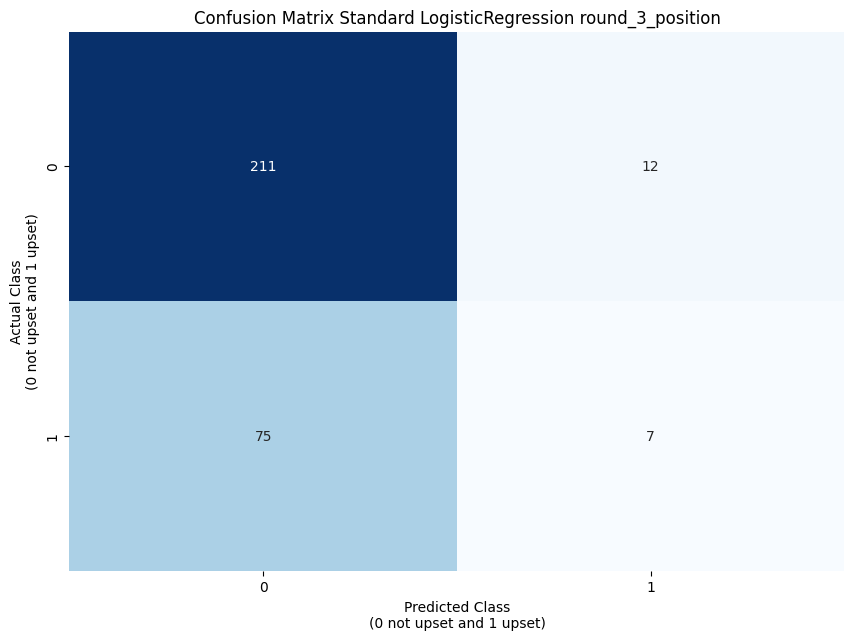

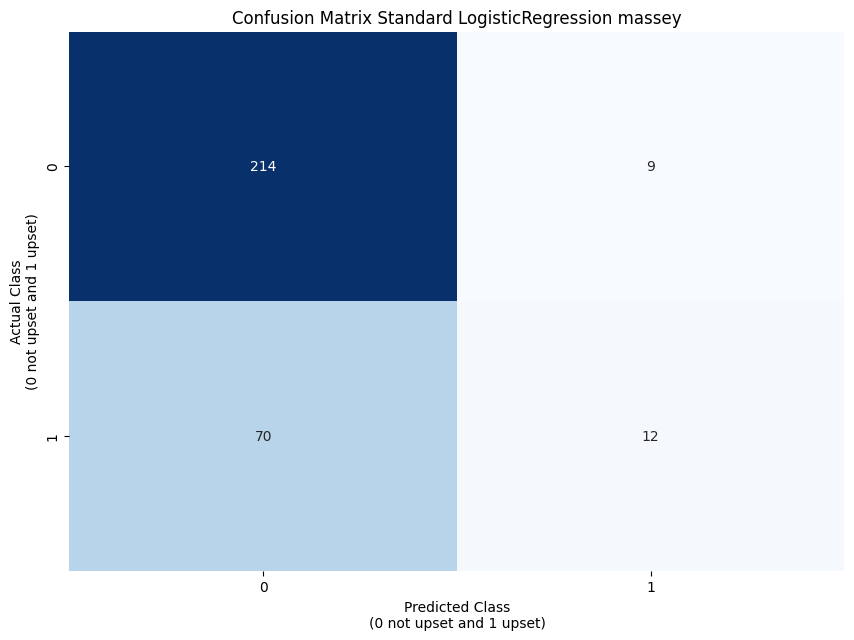

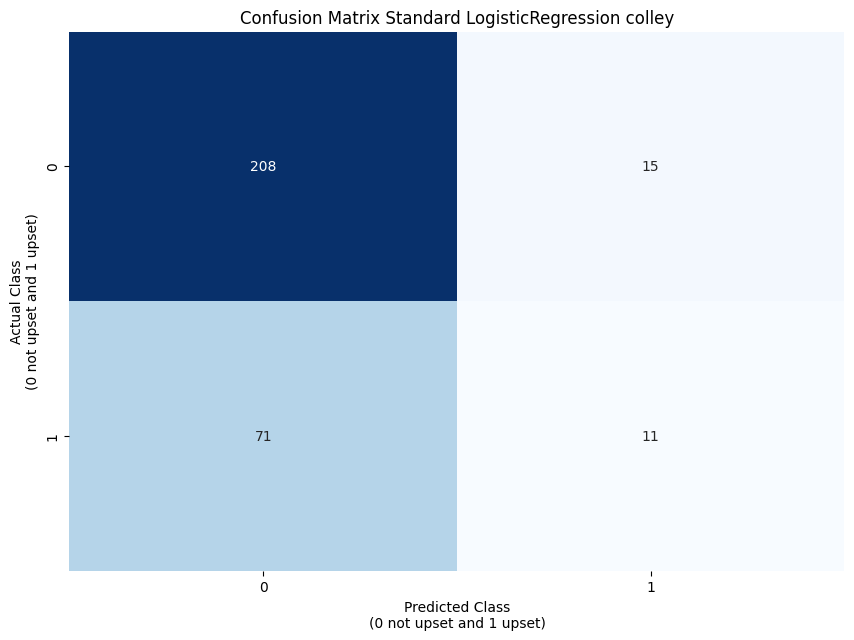

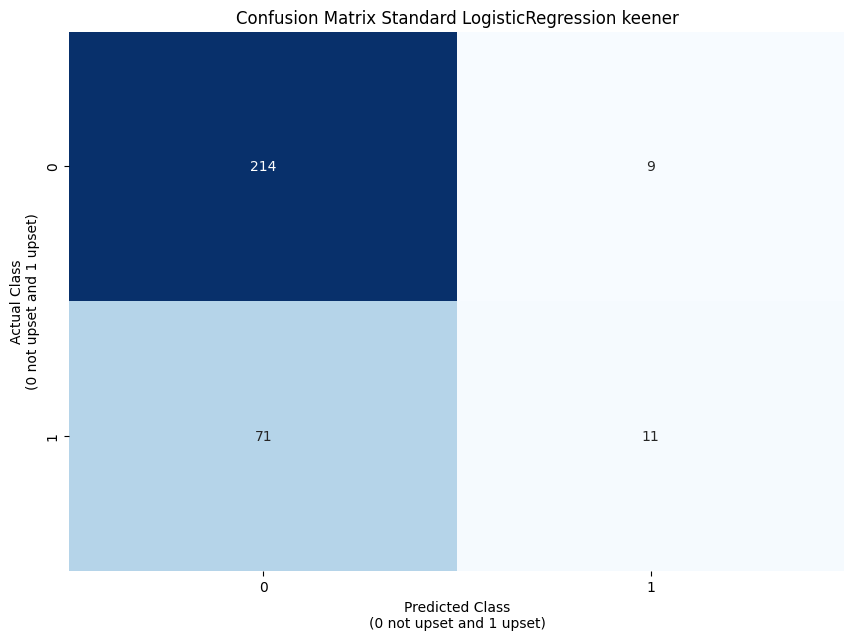

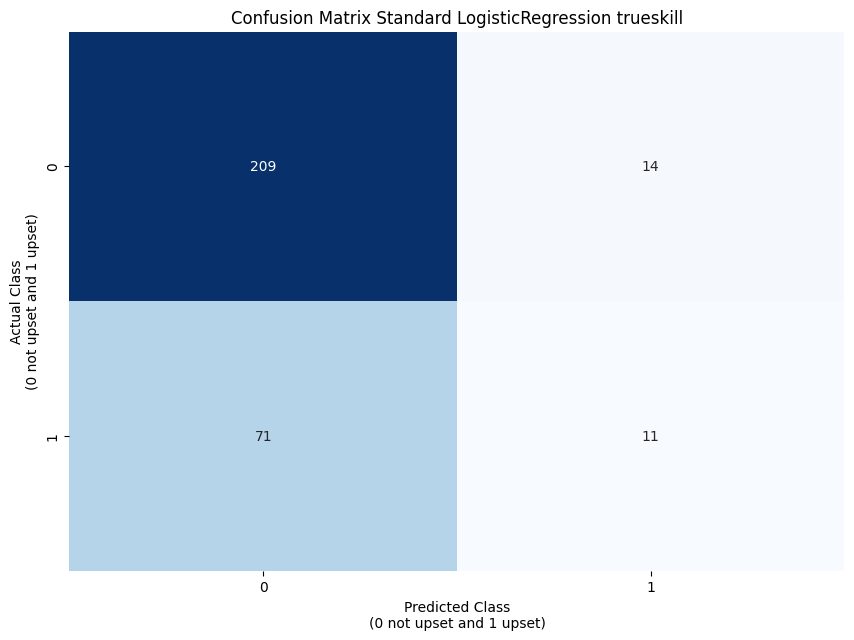

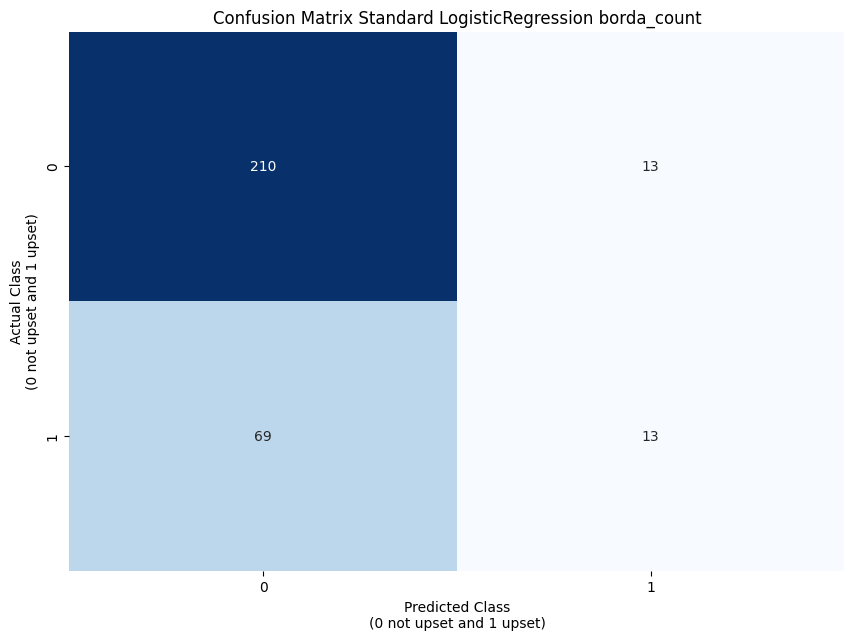

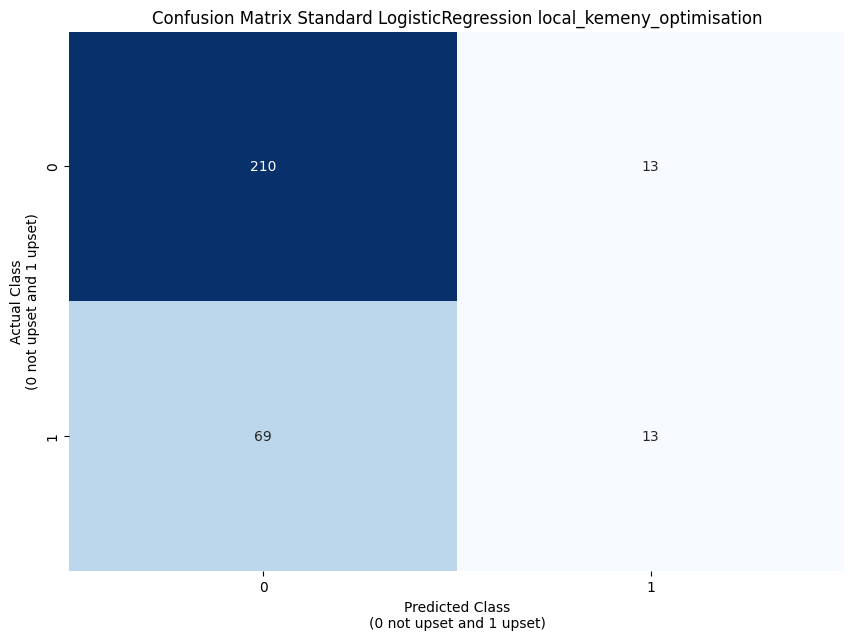

In [85]:
# Standard, no weights
model_name = "Standard LogisticRegression"
# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    #preprocessor = ColumnTransformer(
     #   transformers=[
      #      ('num', numeric_transformer, numeric_features),
       #     ('cat', categorical_transformer, categorical_features),
        #    ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        #], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        X_train, home_advantage_column = add_home_advantage(X_train)
        X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        numeric_features_with_ha = [home_advantage_column] + numeric_features
        #print(numeric_features_with_ha)

        # Update preprocessor with current features including home advantage
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features_with_ha),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        print(f"\nFold {fold}")
        print("Preprocessed Train data:")
        display(X_train_preprocessed_df)
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)


Weighted LogisticRegression round_3_position
Fold 1 Accuracy: 0.557
Fold 2 Accuracy: 0.525
Fold 3 Accuracy: 0.590
Fold 4 Accuracy: 0.639
Fold 5 Accuracy: 0.574
Average Accuracy: 0.577
Weighted LogisticRegression massey
Fold 1 Accuracy: 0.590
Fold 2 Accuracy: 0.541
Fold 3 Accuracy: 0.574
Fold 4 Accuracy: 0.590
Fold 5 Accuracy: 0.525
Average Accuracy: 0.564
Weighted LogisticRegression colley
Fold 1 Accuracy: 0.574
Fold 2 Accuracy: 0.557
Fold 3 Accuracy: 0.607
Fold 4 Accuracy: 0.623
Fold 5 Accuracy: 0.574
Average Accuracy: 0.587
Weighted LogisticRegression keener
Fold 1 Accuracy: 0.590
Fold 2 Accuracy: 0.525
Fold 3 Accuracy: 0.590
Fold 4 Accuracy: 0.607
Fold 5 Accuracy: 0.541
Average Accuracy: 0.570
Weighted LogisticRegression trueskill
Fold 1 Accuracy: 0.590
Fold 2 Accuracy: 0.574
Fold 3 Accuracy: 0.590
Fold 4 Accuracy: 0.607
Fold 5 Accuracy: 0.525
Average Accuracy: 0.577
Weighted LogisticRegression borda_count
Fold 1 Accuracy: 0.590
Fold 2 Accuracy: 0.525
Fold 3 Accuracy: 0.590
Fold 4 A

,metric_id,metric,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation,Weighted LogisticRegression round_3_position,Weighted LogisticRegression massey,Weighted LogisticRegression colley,Weighted LogisticRegression keener,Weighted LogisticRegression trueskill,Weighted LogisticRegression borda_count,Weighted LogisticRegression local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.715,0.738,0.721,0.734,0.711,0.725,0.725,0.577,0.564,0.587,0.570,0.577,0.577,0.574
1,2,Overall Accuracy,0.715,0.738,0.721,0.734,0.711,0.725,0.725,0.577,0.564,0.587,0.570,0.577,0.577,0.574
2,3,Confusion Matrix - True Negative (Class 0),213.000,216.000,212.000,213.000,209.000,212.000,212.000,135.000,134.000,138.000,133.000,136.000,136.000,135.000
3,4,Confusion Matrix - False Positive (Class 1),10.000,7.000,11.000,10.000,14.000,11.000,11.000,88.000,89.000,85.000,90.000,87.000,87.000,88.000
4,5,Confusion Matrix - False Negative (Class 0),77.000,73.000,74.000,71.000,74.000,73.000,73.000,41.000,44.000,41.000,41.000,42.000,42.000,42.000
5,6,Confusion Matrix - True Positive (Class 1),5.000,9.000,8.000,11.000,8.000,9.000,9.000,41.000,38.000,41.000,41.000,40.000,40.000,40.000
6,7,Precision (Class 0),0.734,0.747,0.741,0.750,0.739,0.744,0.744,0.767,0.753,0.771,0.764,0.764,0.764,0.763
7,8,Recall (Class 0),0.955,0.969,0.951,0.955,0.937,0.951,0.951,0.605,0.601,0.619,0.596,0.610,0.610,0.605
8,9,F1-score (Class 0),0.830,0.844,0.833,0.840,0.826,0.835,0.835,0.677,0.668,0.687,0.670,0.678,0.678,0.675
9,10,Precision (Class 1),0.333,0.562,0.421,0.524,0.364,0.450,0.450,0.318,0.299,0.325,0.313,0.315,0.315,0.312


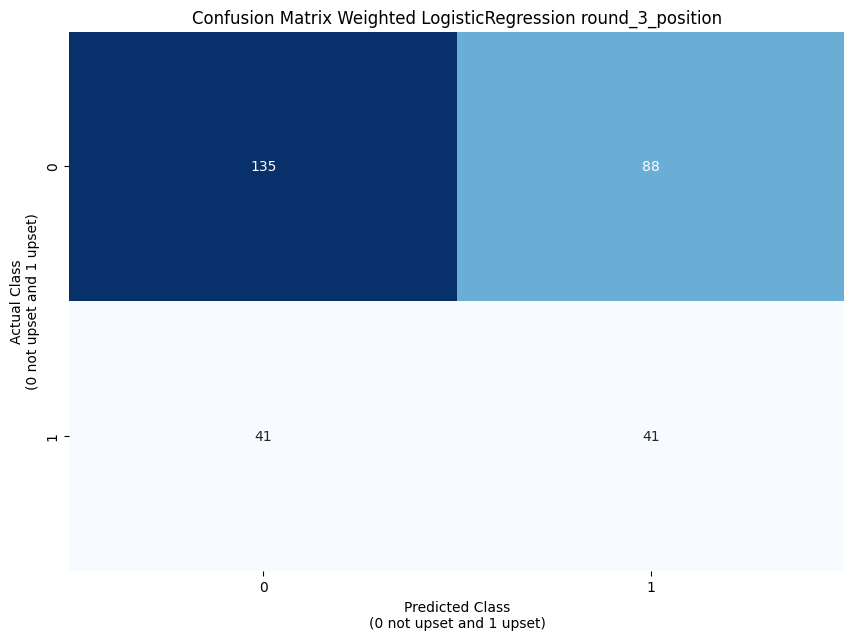

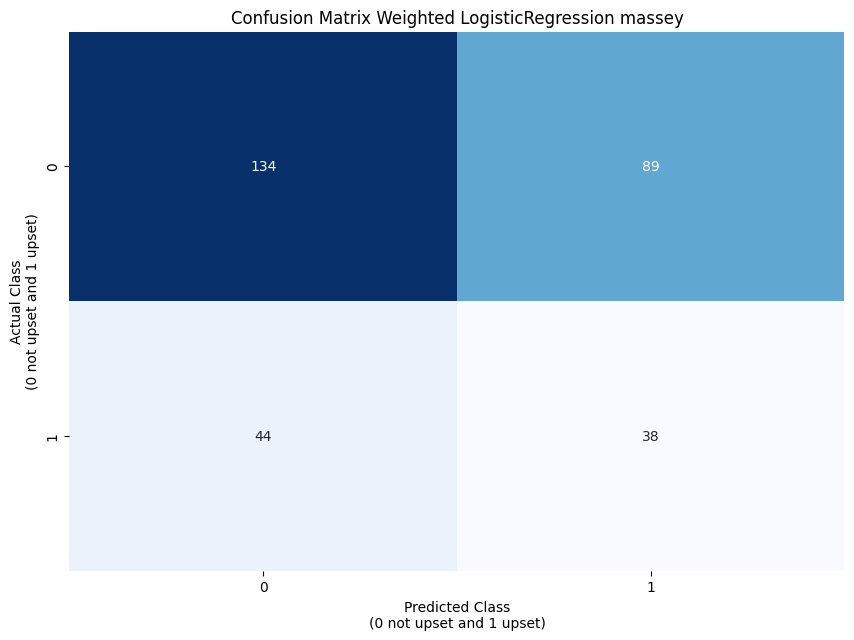

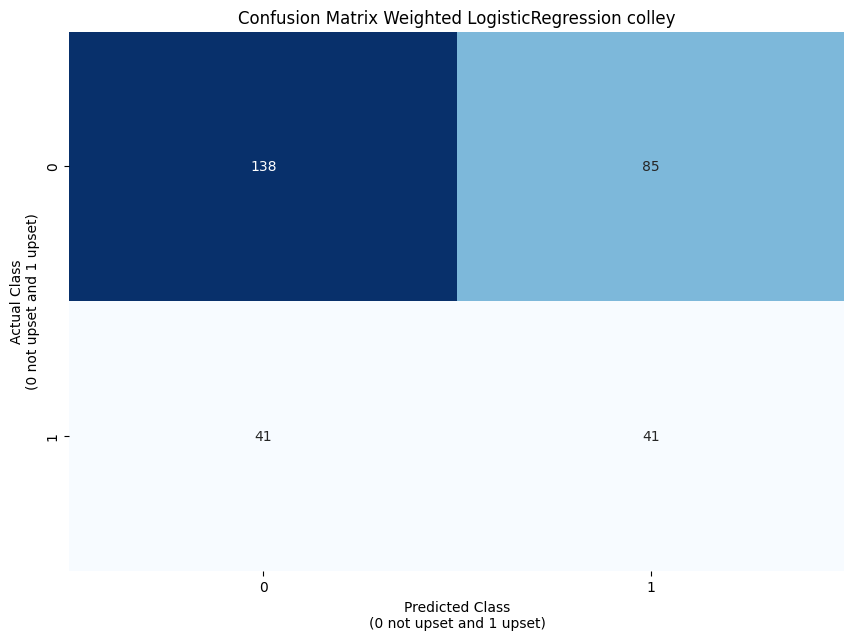

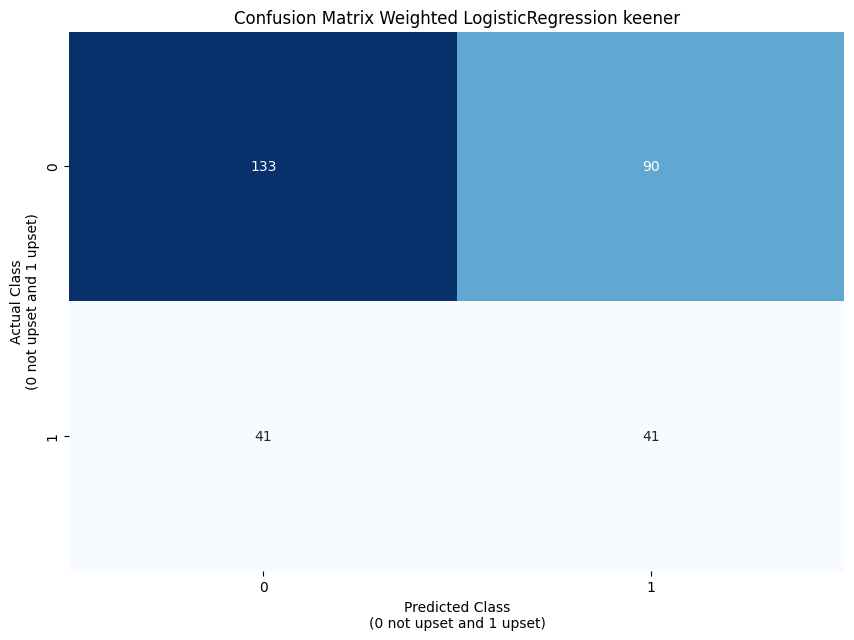

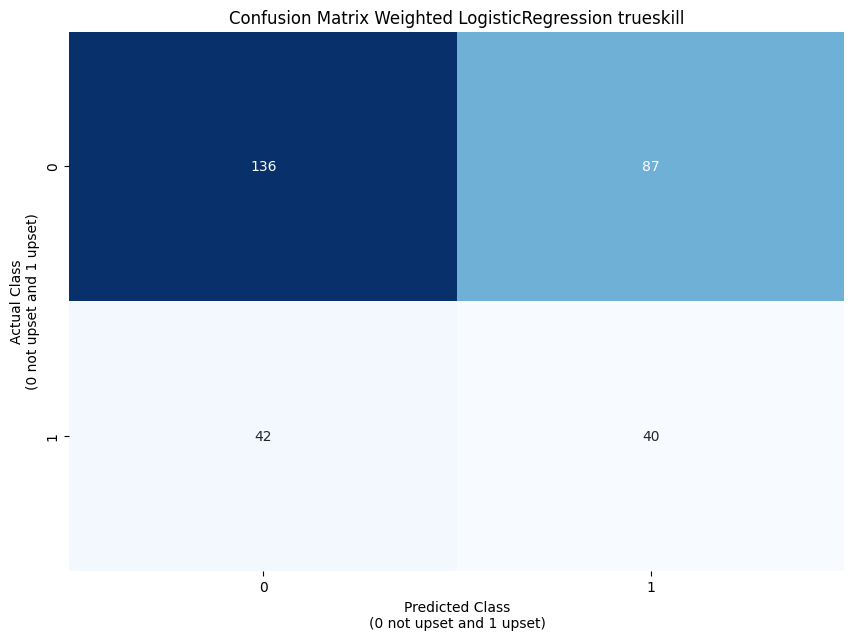

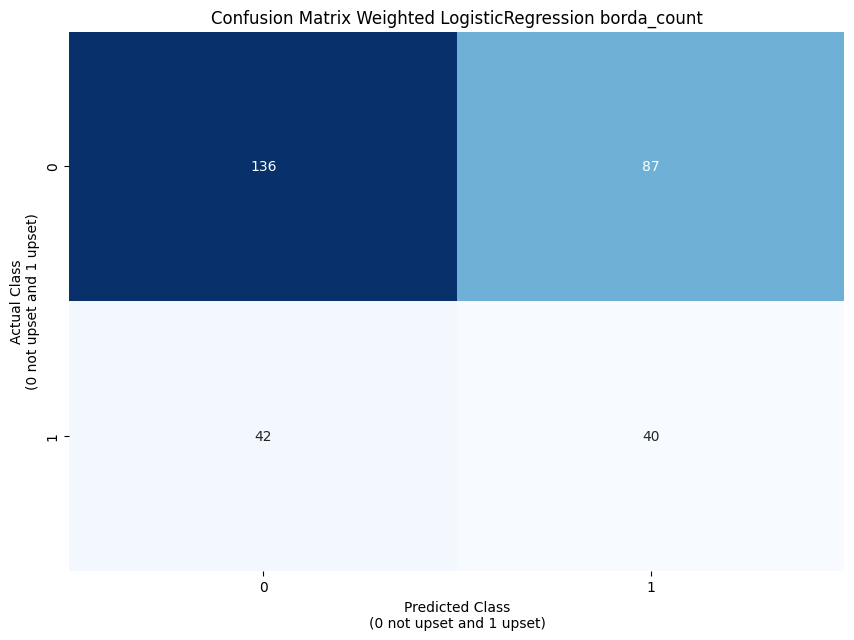

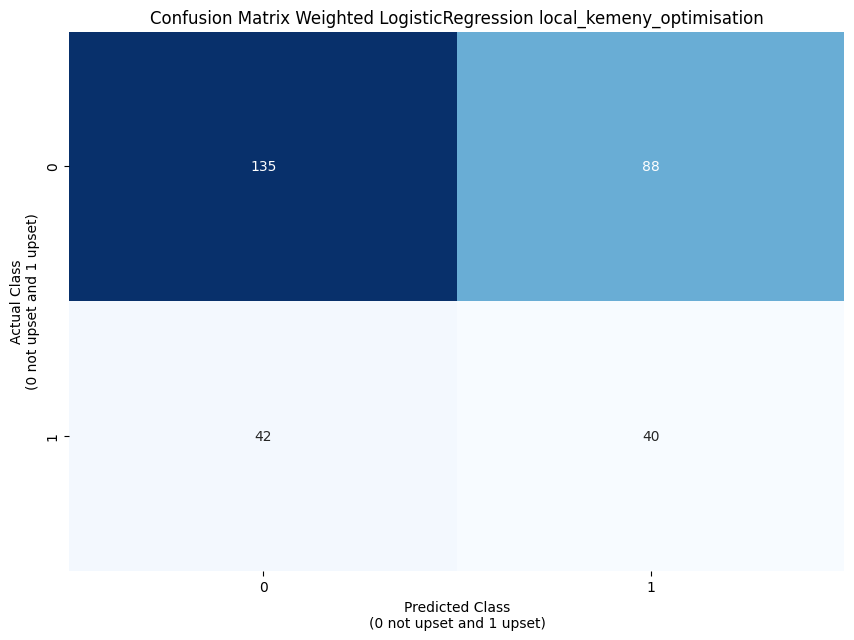

In [61]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)


MLP Classifier Neural Network round_3_position
Fold 1 Accuracy: 0.656
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.689
Fold 4 Accuracy: 0.689
Fold 5 Accuracy: 0.721
Average Accuracy: 0.692
MLP Classifier Neural Network massey
Fold 1 Accuracy: 0.689
Fold 2 Accuracy: 0.656
Fold 3 Accuracy: 0.689
Fold 4 Accuracy: 0.705
Fold 5 Accuracy: 0.689
Average Accuracy: 0.685
MLP Classifier Neural Network colley
Fold 1 Accuracy: 0.705
Fold 2 Accuracy: 0.754
Fold 3 Accuracy: 0.623
Fold 4 Accuracy: 0.689
Fold 5 Accuracy: 0.705
Average Accuracy: 0.695
MLP Classifier Neural Network keener
Fold 1 Accuracy: 0.705
Fold 2 Accuracy: 0.754
Fold 3 Accuracy: 0.672
Fold 4 Accuracy: 0.689
Fold 5 Accuracy: 0.689
Average Accuracy: 0.702
MLP Classifier Neural Network trueskill
Fold 1 Accuracy: 0.607
Fold 2 Accuracy: 0.721
Fold 3 Accuracy: 0.656
Fold 4 Accuracy: 0.705
Fold 5 Accuracy: 0.656
Average Accuracy: 0.669
MLP Classifier Neural Network borda_count
Fold 1 Accuracy: 0.705
Fold 2 Accuracy: 0.754
Fold 3 Accuracy: 0.

,metric_id,metric,Standard LogisticRegression round_3_position,Standard LogisticRegression massey,Standard LogisticRegression colley,Standard LogisticRegression keener,Standard LogisticRegression trueskill,Standard LogisticRegression borda_count,Standard LogisticRegression local_kemeny_optimisation,Weighted LogisticRegression round_3_position,...,MLP Classifier Neural Network trueskill_x,MLP Classifier Neural Network borda_count_x,MLP Classifier Neural Network local_kemeny_optimisation_x,MLP Classifier Neural Network round_3_position_y,MLP Classifier Neural Network massey_y,MLP Classifier Neural Network colley_y,MLP Classifier Neural Network keener_y,MLP Classifier Neural Network trueskill_y,MLP Classifier Neural Network borda_count_y,MLP Classifier Neural Network local_kemeny_optimisation_y
0,1,Cross-validation Accuracy,0.715,0.738,0.721,0.734,0.711,0.725,0.725,0.577,...,0.669,0.711,0.711,0.692,0.685,0.695,0.702,0.669,0.711,0.711
1,2,Overall Accuracy,0.715,0.738,0.721,0.734,0.711,0.725,0.725,0.577,...,0.669,0.711,0.711,0.692,0.685,0.695,0.702,0.669,0.711,0.711
2,3,Confusion Matrix - True Negative (Class 0),213.000,216.000,212.000,213.000,209.000,212.000,212.000,135.000,...,184.000,186.000,186.000,191.000,188.000,188.000,187.000,184.000,186.000,186.000
3,4,Confusion Matrix - False Positive (Class 1),10.000,7.000,11.000,10.000,14.000,11.000,11.000,88.000,...,39.000,37.000,37.000,32.000,35.000,35.000,36.000,39.000,37.000,37.000
4,5,Confusion Matrix - False Negative (Class 0),77.000,73.000,74.000,71.000,74.000,73.000,73.000,41.000,...,62.000,51.000,51.000,62.000,61.000,58.000,55.000,62.000,51.000,51.000
5,6,Confusion Matrix - True Positive (Class 1),5.000,9.000,8.000,11.000,8.000,9.000,9.000,41.000,...,20.000,31.000,31.000,20.000,21.000,24.000,27.000,20.000,31.000,31.000
6,7,Precision (Class 0),0.734,0.747,0.741,0.750,0.739,0.744,0.744,0.767,...,0.748,0.785,0.785,0.755,0.755,0.764,0.773,0.748,0.785,0.785
7,8,Recall (Class 0),0.955,0.969,0.951,0.955,0.937,0.951,0.951,0.605,...,0.825,0.834,0.834,0.857,0.843,0.843,0.839,0.825,0.834,0.834
8,9,F1-score (Class 0),0.830,0.844,0.833,0.840,0.826,0.835,0.835,0.677,...,0.785,0.809,0.809,0.803,0.797,0.802,0.804,0.785,0.809,0.809
9,10,Precision (Class 1),0.333,0.562,0.421,0.524,0.364,0.450,0.450,0.318,...,0.339,0.456,0.456,0.385,0.375,0.407,0.429,0.339,0.456,0.456


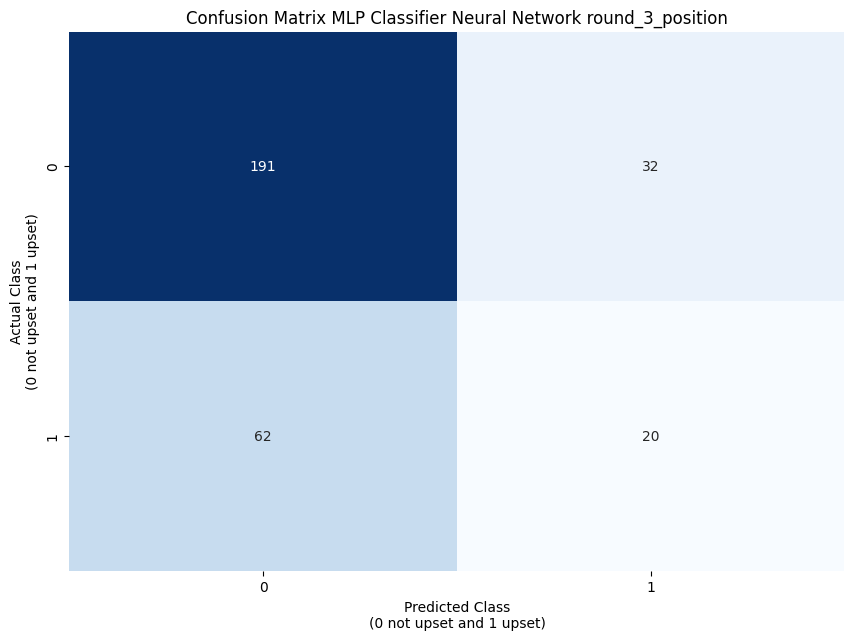

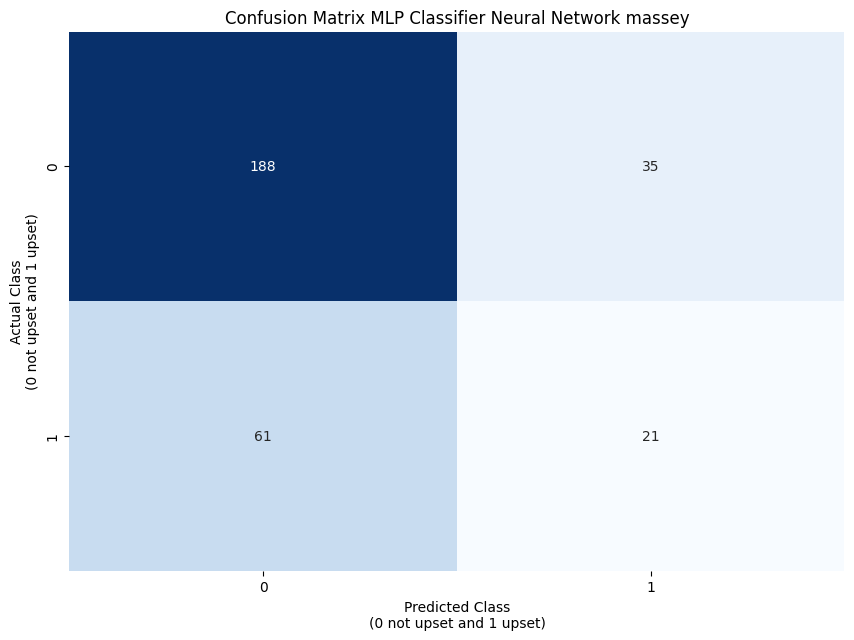

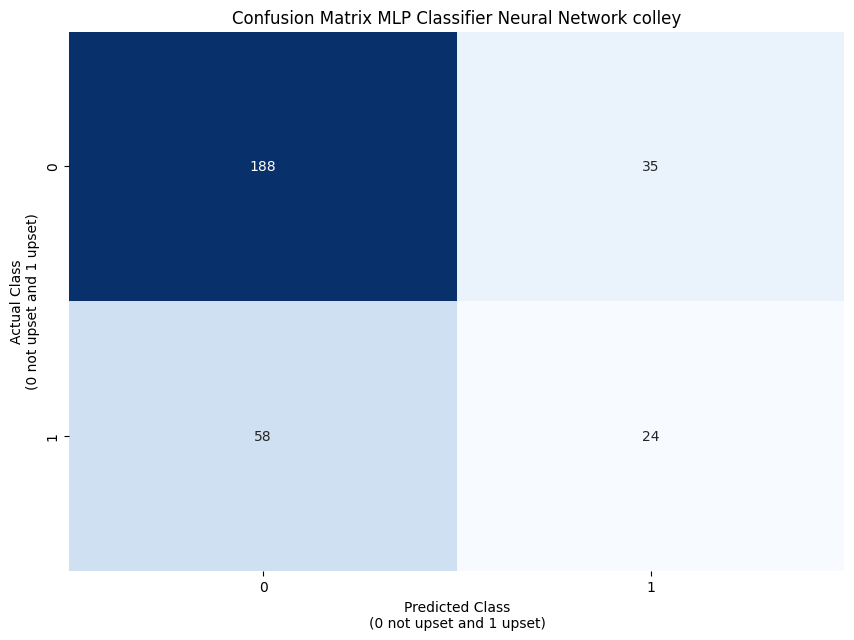

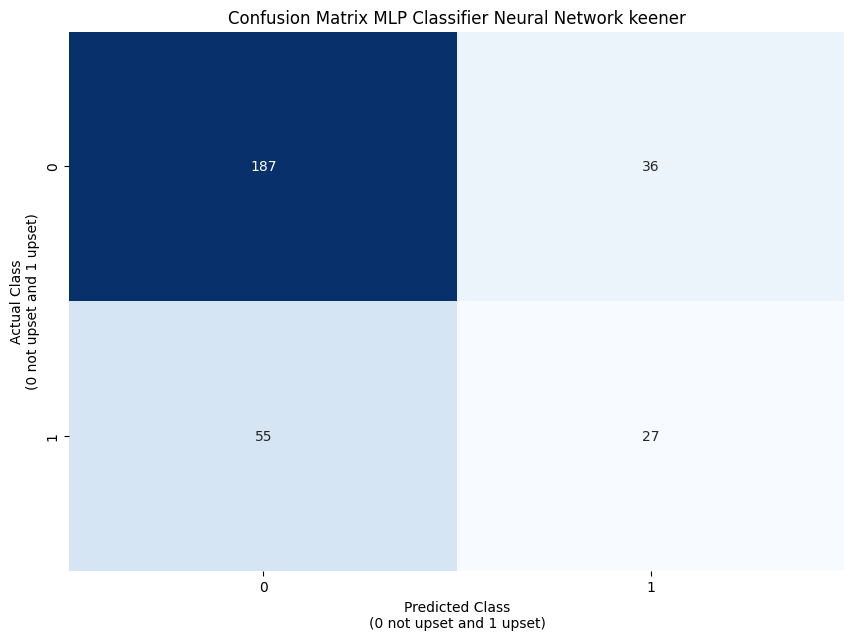

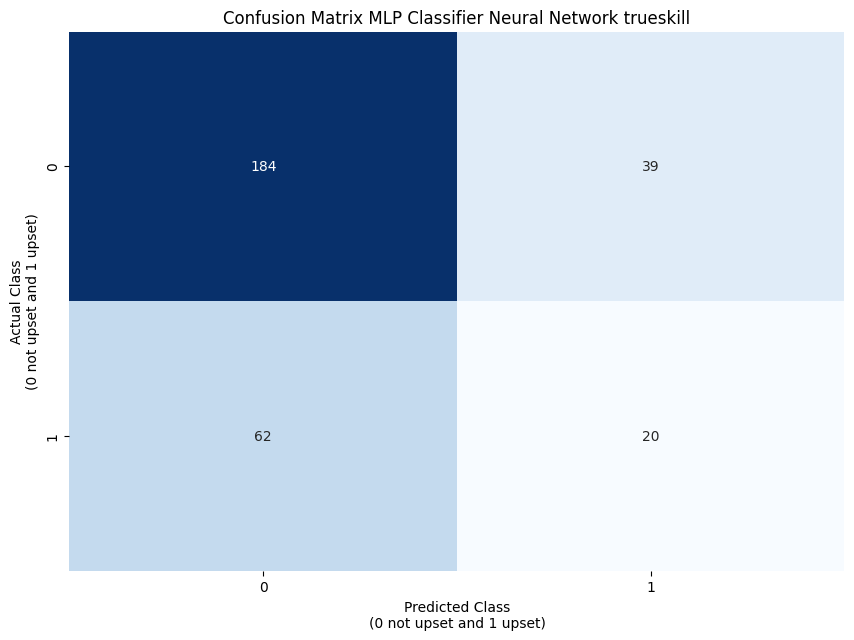

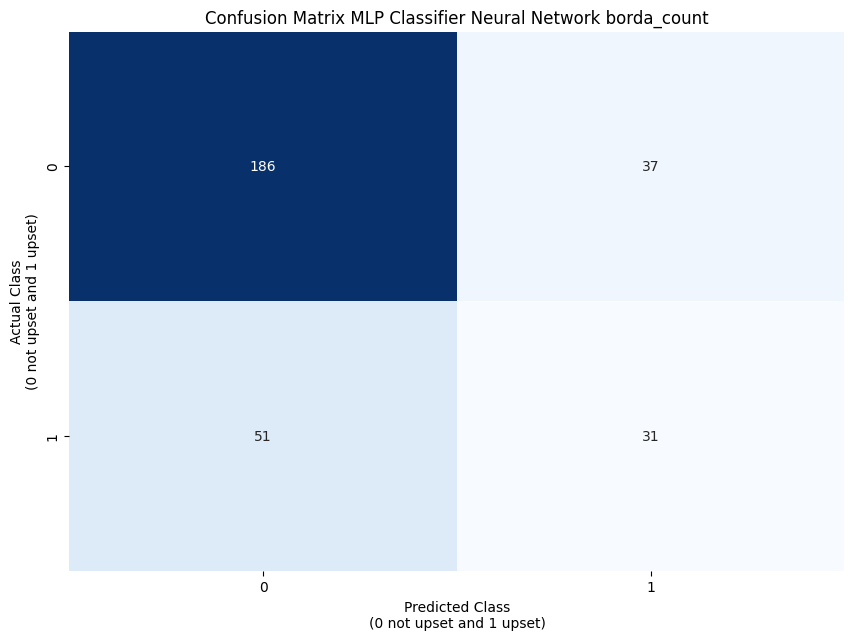

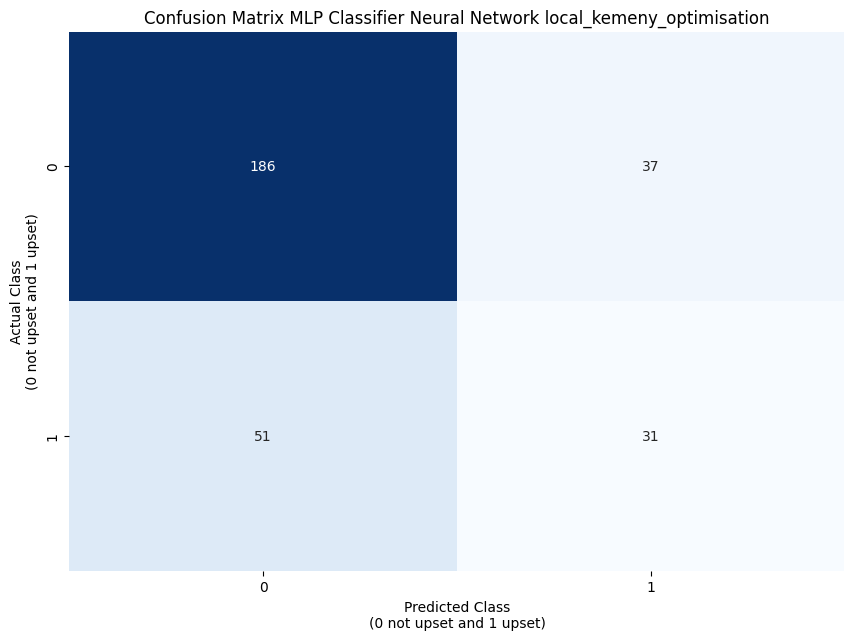

In [63]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
random_state= 47

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)
